# Calibration de modèles GARCH par des méthodes d'apprentissage
---

## Rappels
---

On a :
$$ \sigma_t^2 = \alpha_0 + \alpha_1  x_{t-1}^2 + \beta_1 \sigma_{t-1}^2$$
avec $x_t = \sigma_t Z_t$

## I - Installation des modules
---

In [3]:
# Gestion des modules et des imports

%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import random
import statsmodels

from datetime import datetime

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## II - Mise en place du réseau de neurones
---

On met en place un réseau de neurones à 5 couches :
- une couche d'entrée prenant pour 4 entrées les moments d'ordre 2,4 et 6 ainsi que l'autocovariance pour un lag n = 2.
- une première couche cachée comportant 64 neurones.
- une deuxième couche cachée comportant 128 neurones.
- une troisième couche cachée comportant 64 neurones.
- une couche de sortie a un paramètre.

On utilise des fonctions d'activations ReLU et l'erreur quadratique moyenne comme fonction de perte

In [4]:
# Définition du réseau de neurones

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(6, 64)
        self.layer2 = nn.Linear(64, 128)
        self.layer3 = nn.Linear(128, 128)
        self.layer4 = nn.Linear(128, 64)
        self.layer5 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer4(x))
        x = self.layer5(x)
        return x
    
    def save(self, path):
        torch.save(self.state_dict(), path)
    
    def load(self, path):
        self.load_state_dict(torch.load(path))

# Instanciation du réseau
net = NeuralNetwork()

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.MSELoss()  # Exemple de fonction de perte (erreur quadratique moyenne)
# Optimiseur (Adam)
optimizer = optim.Adam(net.parameters(), lr=0.005)



On définit des fonctions qui déterminent à partir des coefficients $\alpha_0, \alpha_1$ et $\beta_1$ les valeurs des moments normalisés d'odre $2,4$ et $6$ et le $\gamma_2$ du modèle GARCH correspondant.

In [5]:
# Génération des moments d'odre 2,4 et 6

def moments(a0,a1,b1):
    M2 = a0/(1-a1-b1)
    M4 = 3 + 6*a1**2/(1-3*a1**2-2*a1*b1-b1**2)
    M6 = 15*(1-a1-b1)**3*(1+3*(a1+b1)/(1-a1-b1)+3*(1+2*(a1+b1)/(1-a1-b1)*(b1**2+2*a1*b1+3*a1**2)/(1-3*a1**2-2*a1*b1-b1**2)))/(1-15*a1**3-9*a1**2*b1-3*a1*b1**2-b1**3)
    return M2, M4, M6

def autocovariance(a0,a1,b1,n=2):
    gamma = 2*a1*(1-a1*b1-b1**2)*(a1+b1)**(n-1)/(1-3*a1**2-2*a1*b1-b1**2)
    return gamma

On crée une fonction qui génère des coefficients aléatoires puis calcule les moments d'ordre 2, 4 et 6 ainsi que le lag associé.

## III - Entrainement du réseau de neurones
---

In [6]:
# Génération des données d'entrainement

def sigmoid(x):
    return 1/(1+np.exp(-x))

def generate_data(num_samples):
    # Créer des listes pour stocker les données
    inputs = []
    targets = []

    # Générer les données d'entrainement
    for _ in range(num_samples):
        # Générer des paramètres aléatoires pour a0, a1 et b1
        a0 = np.random.rand()*10**(-3) + 10**(-6)
        a1 = np.random.rand()*0.3
        b1 = np.random.rand()
        
        # Calculer les valeurs de sortie en utilisant la fonction f
        y1, y2, y3 = moments(a0, a1, b1)
        y4 = autocovariance(a0, a1, b1, 2)
        y5 = autocovariance(a0, a1, b1, 4)
        y6 = autocovariance(a0, a1, b1, 6)

        # Ajouter les paramètres et les valeurs de sortie aux listes
        inputs.append([y1, y2, y3, y4, y5, y6])
        targets.append([a1])

    # Convertir les listes en tenseurs PyTorch
    return nn.functional.normalize(torch.tensor(inputs, dtype=torch.float32)), torch.tensor(targets, dtype=torch.float32)

Époque [50/1000], Erreur: 0.7006
Époque [100/1000], Erreur: 0.6390
Époque [150/1000], Erreur: 0.4328
Époque [200/1000], Erreur: 0.3233
Époque [250/1000], Erreur: 0.2053
Époque [300/1000], Erreur: 0.1569
Époque [350/1000], Erreur: 0.1182
Époque [400/1000], Erreur: 0.0920
Époque [450/1000], Erreur: 0.0818
Époque [500/1000], Erreur: 0.0310
Époque [550/1000], Erreur: 0.0316
Époque [600/1000], Erreur: 0.0350
Époque [650/1000], Erreur: 0.0236
Époque [700/1000], Erreur: 0.0502
Époque [750/1000], Erreur: 0.0160
Époque [800/1000], Erreur: 0.0338
Époque [850/1000], Erreur: 0.0118
Époque [900/1000], Erreur: 0.0311
Époque [950/1000], Erreur: 0.0200
Époque [1000/1000], Erreur: 0.0311


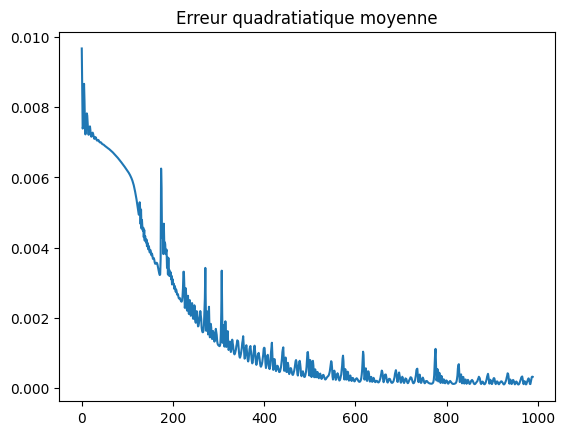

In [7]:
# Boucle d'entraînement

nbrBoucle = 1000
bachSize = 200

inputs_tensor, targets_tensor = generate_data(bachSize)

error = []

for epoch in range(nbrBoucle): 
    optimizer.zero_grad()  # Réinitialiser les gradients

    # Passage avant dans le réseau
    outputs = net(inputs_tensor)

    # Calcul de la perte
    loss = criterion(outputs, targets_tensor)
    
    # Calcul des gradients et mise à jour des poids
    loss.backward()
    optimizer.step()
    error.append(loss.item())
    if (epoch + 1) % 50 == 0:
        print(f'Époque [{epoch+1}/{nbrBoucle}], Erreur: {100*loss.item():.4f}')

plt.plot(error[10:])
plt.title("Erreur quadratiatique moyenne")
plt.show()


## IV - Analyse des résultats
---

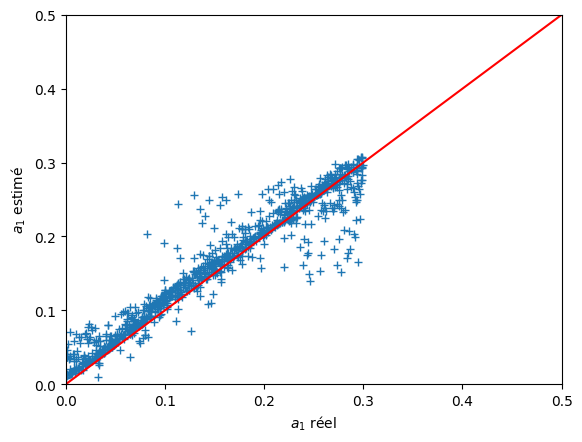

In [8]:
# Affichage des résultats

inputs_tensor, targets_tensor = generate_data(1000)
plt.plot(targets_tensor.detach().numpy(),net(inputs_tensor).detach().numpy(), marker = '+', linestyle = 'None')
plt.xlabel('$a_1$ réel')
plt.ylabel('$a_1$ estimé')
plt.plot([0,0.5],[0,0.5], color = 'red')
plt.xlim(0,0.5)
plt.ylim(0,0.5)
plt.show()

In [9]:
# Sauvegarde du modèle

heure = datetime.now().strftime("%Y-%m-%d %H-%M-%S")

#net.save(f'model{heure}.pt')

In [10]:
# Génération de données de test et estimation des moments

def signal(n, a0, a1, b1):
    signalTab = np.zeros(n)
    sigma = a0
    signalTab[0] = a0 * np.random.normal(0, 1)
    for i in range(1, n):
        sigma = np.sqrt(a0 + a1 * signalTab[i-1]**2 + b1 * sigma**2)
        signalTab[i] = sigma * np.random.normal(0, 1)
    return signalTab

def estimateMoments(signalTab):
    n = len(signalTab)
    y1 = signalTab.var()
    y2 = ((signalTab - signalTab.mean())**4).mean()/y1
    y3 = ((signalTab - signalTab.mean())**6).mean()/y1**2
    y4 = np.cov(signalTab[:-2], signalTab[2:])/y1
    y5 = np.cov(signalTab[:-4], signalTab[4:])/y1**2
    y6 = np.cov(signalTab[:-6], signalTab[6:])/y1**3
    return nn.functional.normalize(torch.tensor([[y1, y2, y3, y4, y5, y6]], dtype=torch.float32))

In [11]:
# Vérification de l'estimation des moments

nbrBoucle = 1000



for i in range(nbrBoucle):
    signalTab = signal(1000, 0.001, 0.2, 0.5)
    print(net(estimateMoments(signalTab)))

C:\Users\thoma\AppData\Local\Temp\ipykernel_14152\2526279217.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  return nn.functional.normalize(torch.tensor([[y1, y2, y3, y4, y5, y6]], dtype=torch.float32))


TypeError: only size-1 arrays can be converted to Python scalars